In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.model_selection import train_test_split

# Data

In [ ]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:, 1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

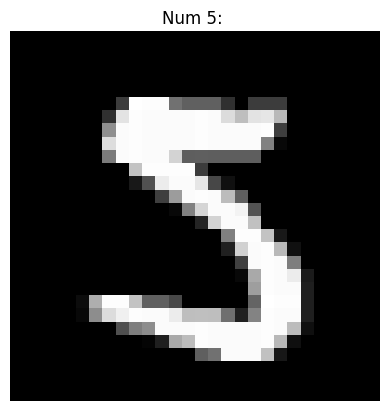

In [ ]:
rand_row = np.random.randint(data.shape[0])
img = np.reshape(data_norm[rand_row], (28,28))
num = labels[rand_row]

plt.imshow(img, cmap = 'grey')
plt.title('Num %d: '%num)
plt.axis(False)
plt.show()

# Split

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Data

In [ ]:
def ModelCreate(optimizer, lr):
  class ModelArch(nn.Module):
    def __init__(self):
      super().__init__()
      self.optimizer = optimizer
      self.lr = lr

      self.input = nn.Linear(784, 128)
      self.f1 = nn.Linear(128, 64)
      self.f2 = nn.Linear(64, 64)
      self.output = nn.Linear(64, 10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.f1(x))
      x = F.relu(self.f2(x))
      x = self.output(x)
      return x

  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optim = optimizer(ann.parameters(), lr = lr)

  return ann, loss_fn, optim

In [ ]:
ann, loss_fn, optimizer = ModelCreate(optimizer = torch.optim.SGD, lr = 1e-3)
X, y = next(iter(train_dataloader))
y_hat = ann(X)
loss = loss_fn(y_hat, y)
loss

tensor(2.2976, grad_fn=<NllLossBackward0>)

# Train

In [ ]:
def ModelTrain(epochs, optimizer, lr, verbose):
  net, loss_fn, optimizer = ModelCreate(optimizer, lr)

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs

In [ ]:
train_accs, test_accs = ModelTrain(epochs = 100, optimizer = torch.optim.Adam, lr = 1e-3, verbose = True)

Epoch: 0 | Train Acc: 80.17 | Test Acc: 89.47 | Loss: 0.68
Epoch: 10 | Train Acc: 98.96 | Test Acc: 95.07 | Loss: 0.04
Epoch: 20 | Train Acc: 99.61 | Test Acc: 96.15 | Loss: 0.01
Epoch: 30 | Train Acc: 100.00 | Test Acc: 96.50 | Loss: 0.00
Epoch: 40 | Train Acc: 100.00 | Test Acc: 96.53 | Loss: 0.00
Epoch: 50 | Train Acc: 100.00 | Test Acc: 96.38 | Loss: 0.00
Epoch: 60 | Train Acc: 100.00 | Test Acc: 96.43 | Loss: 0.00
Epoch: 70 | Train Acc: 100.00 | Test Acc: 96.30 | Loss: 0.00
Epoch: 80 | Train Acc: 100.00 | Test Acc: 96.32 | Loss: 0.00
Epoch: 90 | Train Acc: 100.00 | Test Acc: 96.30 | Loss: 0.00


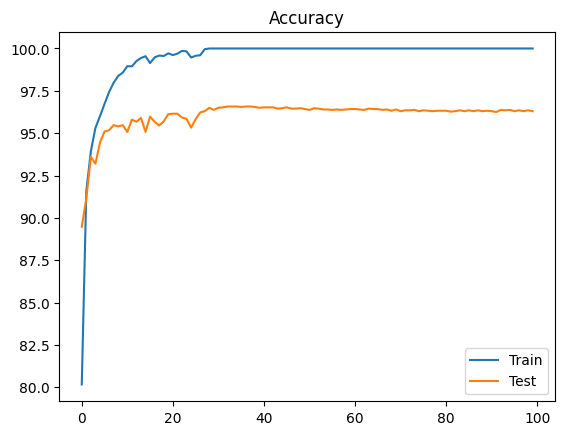

In [ ]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['Train', 'Test'])
plt.title('Accuracy')
plt.show()

# Experiment

In [ ]:
optimizers = [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adam]
lrs = np.logspace( np.log10(1e-4), np.log10(.1), 6 )
epochs = 100

ex_train_accs = torch.zeros((epochs, len(optimizers), len(lrs)))
ex_test_accs = torch.zeros((epochs, len(optimizers), len(lrs)))

for optim_idx, optim in enumerate(optimizers):
  for lr_idx, lr in enumerate(lrs):
    print(f'\n\nProcessing optim: {optim}, lr: {lr}')
    train_accs, test_accs = ModelTrain(epochs = epochs, optimizer = optim, lr = lr, verbose = True)

    ex_train_accs[:, optim_idx, lr_idx] = torch.tensor(train_accs)
    ex_test_accs[:, optim_idx, lr_idx] = torch.tensor(test_accs)



Processing optim: <class 'torch.optim.sgd.SGD'>, lr: 0.0001
Epoch: 0 | Train Acc: 11.92 | Test Acc: 12.05 | Loss: 2.30
Epoch: 10 | Train Acc: 12.46 | Test Acc: 12.38 | Loss: 2.30
Epoch: 20 | Train Acc: 12.53 | Test Acc: 12.45 | Loss: 2.30
Epoch: 30 | Train Acc: 12.34 | Test Acc: 12.15 | Loss: 2.30
Epoch: 40 | Train Acc: 12.13 | Test Acc: 12.05 | Loss: 2.30
Epoch: 50 | Train Acc: 12.01 | Test Acc: 11.98 | Loss: 2.30
Epoch: 60 | Train Acc: 11.91 | Test Acc: 11.93 | Loss: 2.30
Epoch: 70 | Train Acc: 11.90 | Test Acc: 11.98 | Loss: 2.29
Epoch: 80 | Train Acc: 11.91 | Test Acc: 11.93 | Loss: 2.29
Epoch: 90 | Train Acc: 11.99 | Test Acc: 11.95 | Loss: 2.29


Processing optim: <class 'torch.optim.sgd.SGD'>, lr: 0.00039810717055349735
Epoch: 0 | Train Acc: 7.69 | Test Acc: 7.47 | Loss: 2.31
Epoch: 10 | Train Acc: 16.24 | Test Acc: 16.00 | Loss: 2.30
Epoch: 20 | Train Acc: 20.48 | Test Acc: 20.60 | Loss: 2.29
Epoch: 30 | Train Acc: 22.10 | Test Acc: 21.98 | Loss: 2.28
Epoch: 40 | Train Acc: 3

In [ ]:
import plotly.express as px
import pandas as pd

# dane do DataFrame’a
data = []
for optim_idx, optim in enumerate(optimizers):
    for lr_idx, lr in enumerate(lrs):
        for epoch, acc in enumerate(ex_train_accs[:, optim_idx, lr_idx]):
            data.append({
                "Epoch": epoch,
                "Accuracy": acc,
                "Optimizer": str(optim).split(".")[-1],
                "LR": lr,
                "Type": "Train"
            })
        for epoch, acc in enumerate(ex_test_accs[:, optim_idx, lr_idx]):
            data.append({
                "Epoch": epoch,
                "Accuracy": acc,
                "Optimizer": str(optim).split(".")[-1],
                "LR": lr,
                "Type": "Test"
            })

df = pd.DataFrame(data)

# wykres interaktywny
fig = px.line(df, x="Epoch", y="Accuracy",
              color="Optimizer", line_dash="LR",
              facet_col="Type",
              hover_data=["LR"])

fig.update_layout(title="Optimizer & LR Comparison", template="plotly_white")
fig.show()
